100%|██████████| 50000/50000 [00:04<00:00, 12195.94it/s]


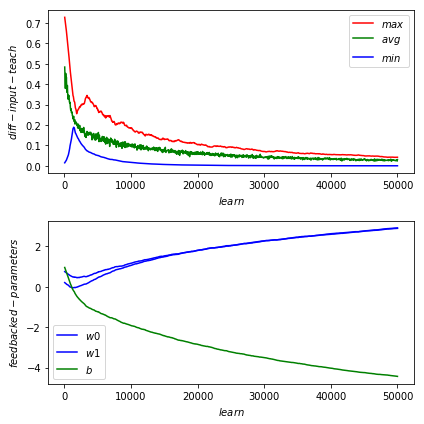

In [1]:
"""
単純パーセプトロンによる機械学習モデル

活性化関数：ロジスティックシグモイド
誤差関数：二乗誤差
学習の種類：論理積
"""

import numpy as np
% matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm


"""
活性化関数
ニューロンの状態値を出力のために調整する
"""
class AbsActivationFunc:
    """
    抽象クラス
    """
    def __call__(self, state):
        raise NotImplementedError
        
    def get_derivative(self, output):
        raise NotImplementedError


class LogisticSigmoid(AbsActivationFunc):
    """
    ロジスティックシグモイド関数
    0 < output < 1
    入力した値が大きければ大きいほど1に近づき、
    入力した値が小さければ小さいほど0に近づく
    """
    def __call__(self, state):
        """
        関数の処理値を返す
        :param float state: ニューロンの状態値
        :return float: 処理値
        """
        return 1. / (1. + np.exp(-state))
    
    def get_derivative(self, output):
        """
        関数の微分値を返す
        ∂y
        ---
        ∂s
        y:output, s:ニューロンの状態値
        :param float output: ニューロンの出力値
        :return float: 微分値
        """
        return output * (1 - output)


"""
誤差関数
ニューロンの出力値と教師データの差を返す
"""
class AbsErrorFunc:
    """
    抽象クラス
    """
    def __call__(self, output, teach_datum):
        raise NotImplementedError
        
    def get_derivative(self, output, teach_datum):
        raise NotImplementedError


class SquaredError(AbsErrorFunc):
    """
    誤差関数(二乗誤差)
    """
    def __call__(self, output, teach_datum):
        """
        関数の処理値を返す
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 処理値
        """
        return np.power(output - teach_datum, 2).sum()
    
    def get_derivative(self, output, teach_datum):
        """
        関数の微分値を返す
        ∂E
        ---
        ∂y
        E:誤差, y:output
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 微分値
        """
        return output - teach_datum


"""
教師データ(入力値に対する回答値)を取得
学習ループ毎に一度だけ実行される
"""
class AbsTeachData:
    """
    抽象クラス
    """
    def __call__(self, inputs):
        raise NotImplementedError


class LogisticAnd(AbsTeachData):
    """
    論理積
    """
    def __call__(self, inputs):
        """
        関数の処理値を返す
        :param ndarray float inputs: 入力値
        :return float: 出力値　0.0 or 1.0
        """
        return 0.0 if (inputs[inputs == 0.0].size) else 1.0


"""
単純パーセプトロンのニューロンクラス
"""
class Neuron:
    def __init__(self, 
        input_num, 
        activation_func, 
        error_func
    ):
        """
        初期化
        :param integer input_num: ニューロンへの入力数
        :param class activation_func: 活性化関数class
        :param class error_func: 誤差関数class
        """
        # ニューロン単体への入力数
        self._input_num = input_num
        # 重み付け(入力数と同数列)
        self._weights = np.random.rand(1, self._input_num)
        # バイアス
        self._bias = 1.
        # ニューロンの状態値
        self._state = None
        # 　ニューロンからの出力値
        self._output = None
        # 誤差伝播値
        self._delta = None
        # 学習率
        self._learning_rate = 0.01
        # 活性化関数
        self._activation_func = activation_func
        # 誤差関数
        self._error_func = error_func

    def propagate_forward(self, inputs):
        """
        伝播プロセス
        該当層の各ニューロンへの入力値による出力値を計算、セット
        :param ndarray float inputs: 入力値
        :return float output: ニューロンの出力値
        """
        # 重み付けと入力値の行列の内積を計算し、ニューロンの状態値を更新
        self._state = self._weights.dot(inputs) + self._bias
        # 活性化関数で出力値を調整
        self._output = self._activation_func(self._state)
        return self._output

    def propagate_backward(self, output, teach_datum):
        """
        逆伝播プロセス
        ニューロンの保持する誤差情報のセット
        ∂E    ∂y
        --- * ---
        ∂y    ∂s
        E:誤差, y:output, s:ニューロンの状態値
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 誤差値
        """
        self._delta = self._error_func.get_derivative(output, teach_datum) \
                            * self._activation_func.get_derivative(output)
        return self._delta

    def update(self, delta, inputs):
        """
        重み付け、バイアスの更新
        :param float delta: 誤差値
        :param ndarray float inputs: 入力値
        """
        # 重み付け更新
        self._weights -= (self._learning_rate * delta * inputs.T)
        # バイアス更新
        self._bias -= self._learning_rate * delta

    def get_diff(self, output, teach_datum):
        """
        出力層のニューロンの出力値と教師データの差を返す（グラフ出力用）
        :param float output: ニューロンの出力値
        :param float teach_datum: 入力値に対する教師データ
        :return float: 
        """
        return self._error_func(output, teach_datum)

    def get_weights(self):
        """
        重み付けの値を取得（グラフ出力用）
        :return ndarray float: 
        """
        return self._weights

    def get_bias(self):
        """
        バイアスの値を取得（グラフ出力用）
        :return ndarray float: 
        """
        return self._bias

    def get_state(self):
        """
        ニューロンの状態値を取得（グラフ出力用）
        :return ndarray float: 
        """
        return self._state


"""
実行&グラフ出力
"""
if __name__ == '__main__':
    # ニューロンへの入力数
    input_num = 2
    # 学習回数
    learn_num = 50000
    # プロットのインターバル
    interval = 50

    # 学習開始
    n = Neuron(input_num, LogisticSigmoid(), SquaredError())
    t = LogisticAnd()
    # 誤差グラフ用
    graph_diff_x = []
    tmp_graph_diff_y = []
    graph_diff_y_max = []
    graph_diff_y_avg = []
    graph_diff_y_min = []
    # 重み付けグラフ用
    graph_w_x = []
    graph_w_y = []
    for h in range(0, input_num):
        graph_w_y.append([])
    # バイアスグラフ用
    graph_b_x = []
    graph_b_y = []
    for i in tqdm(range(1, learn_num+1)):
        # 入力値をランダムに生成
        inputs = np.round(np.random.rand(input_num, 1))
        # 伝播プロセス
        output = n.propagate_forward(inputs)
        # 教師データ(入力値に対する回答値)を取得
        teach_datum = t(inputs)
        # 逆伝播プロセス
        delta = n.propagate_backward(output, teach_datum)
        # パラメータ更新
        n.update(delta, inputs)
        # 出力層のニューロンの出力値と教師データの差を取得
        tmp_graph_diff_y.append(n.get_diff(output, teach_datum))
        if i % interval == 0:
            # インターバル毎の誤差値の最大値、平均値、最小値をプロット
            # 誤差グラフ用
            graph_diff_x.append(i)
            graph_diff_y_max.append(max(tmp_graph_diff_y))
            graph_diff_y_avg.append(sum(tmp_graph_diff_y) / len(tmp_graph_diff_y))
            graph_diff_y_min.append(min(tmp_graph_diff_y))
            tmp_graph_diff_y = []
            # 重み付けグラフ用
            graph_w_x.append(i)
            w = n.get_weights().T
            for j in range(0, input_num):
                graph_w_y[j].append(w[j][0])
            # バイアスグラフ用
            graph_b_x.append(i)
            graph_b_y.append(n.get_bias()[0][0])

    # グラフ
    plt.figure(figsize=(6,6))
    plt.style.use('grayscale')
    gs = gridspec.GridSpec(2,1)
    # 誤差グラフ
    graph_diff = plt.subplot(gs[0, :])
    line_diff_max, line_diff_avg, line_diff_min = graph_diff.plot(
        graph_diff_x, graph_diff_y_max, 'r-', 
        graph_diff_x, graph_diff_y_avg, 'g-', 
        graph_diff_x, graph_diff_y_min, 'b-'
    )
    graph_diff.legend((line_diff_max, line_diff_avg, line_diff_min), ('$max$', '$avg$', '$min$'))
    graph_diff.set_xlabel('$learn$')
    graph_diff.set_ylabel('$diff-input-teach$')
    # フィードバックされるパラメータ用
    graph_feedbacked_params = plt.subplot(gs[1, :])
    line_feedbacked_params = []
    line_feedbacked_params_legend = []
    # 重み付け
    for k in range(0, input_num):
        line_feedbacked_params.append(graph_feedbacked_params.plot(graph_w_x, graph_w_y[k], 'b-')[0])
        line_feedbacked_params_legend.append('$w'+str(k)+'$')
    # バイアス
    line_feedbacked_params.append(graph_feedbacked_params.plot(graph_b_x, graph_b_y, 'g-')[0])
    line_feedbacked_params_legend.append('$b$')
    graph_feedbacked_params.legend(line_feedbacked_params, line_feedbacked_params_legend)
    graph_feedbacked_params.set_xlabel('$learn$')
    graph_feedbacked_params.set_ylabel('$feedbacked-parameters$')
    # 出力
    plt.tight_layout()
    plt.show()